### Purpose  
We set the data to stationary so we can fit the model and we can do some forecasting.  


### Model
I choose `fbprophet` (Facebook Prophet) as a model. Facebook Prophet is an open-source algorithm for generating time-series models that uses a few old ideas with some new twists. It is particularly good at modeling time series that have multiple seasonalities and doesn't face some of the above drawbacks of other algorithms.  

<img src='../Images/prophet.png' style="float: left;margin:5px 20px 5px 1px" width='400' height='120'>

### Capabilities  

**Accurate and fast**  
Prophet is used in many applications across Facebook for producing reliable forecasts for planning and goal setting. We’ve found it to perform better than any other approach in the majority of cases. We fit models in Stan so that you get forecasts in just a few seconds.  


**Full automatic**  
Get a reasonable forecast on messy data with no manual effort. Prophet is robust to outliers, missing data, and dramatic changes in your time series.  

**Tunable Forcasts**  
The Prophet procedure includes many possibilities for users to tweak and adjust forecasts. You can use human-interpretable parameters to improve your forecast by adding your domain knowledge.  



In [98]:
import pandas as pd 
import numpy as np 
from prophet import Prophet

df = pd.read_csv('../Datasets/full_data.csv')
df.set_index('date', inplace=True)
df.columns = ['y']

df.head()

,y
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [99]:
# Centered Moving Average 
df['cma-y'] = df['y'].rolling(window=3, center=True).mean()
df.head()

,y,cma-y
date,,
2013-01-01,10.000000,NaN
2013-01-02,7.400000,8.188889
2013-01-03,7.166667,7.744444
2013-01-04,8.666667,7.277778
2013-01-05,6.000000,7.222222


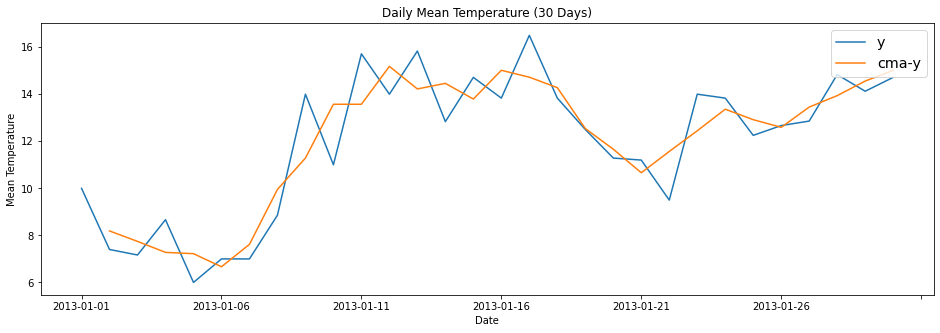

In [100]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(figsize=(16,5))
df.iloc[:30,:].plot(ax = ax)
# ax.figure.set_size_inches((20,5))
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature')
ax.set_title('Daily Mean Temperature (30 Days)')
ax.legend(loc='upper right', fontsize='x-large')

fig.savefig('../Images/prophet_cma_plot.png')
plt.show()

In [101]:
def do_fitting(data, date_column, value_column, cutoff, freq='W', prediction_periods=12, country_name='TR'):
    data = data.reset_index()[[date_column, value_column]].dropna(axis=0)
    data.columns = ['ds', 'y']
    training_data = data[data['ds'] < cutoff]
    test_data = data[data['ds'] > cutoff]
    model = Prophet()
    model.add_country_holidays(country_name=country_name)
    model.fit(training_data)
    future = model.make_future_dataframe(periods=prediction_periods, freq=freq)
    forecast = model.predict(future)
    return model, forecast, training_data, test_data

In [102]:
model, forecast, train, test = do_fitting(data=df, date_column='date', value_column='y',
                                        cutoff='2017-01-01', freq='D', country_name='IN', prediction_periods=365)
# D -> daily
# W -> weekly
# M -> monthly
# Y -> yearly

c:\Users\ramaz\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
20:54:31 - cmdstanpy - INFO - Chain [1] start processing
20:54:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ramaz\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
c:\Users\ramaz\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


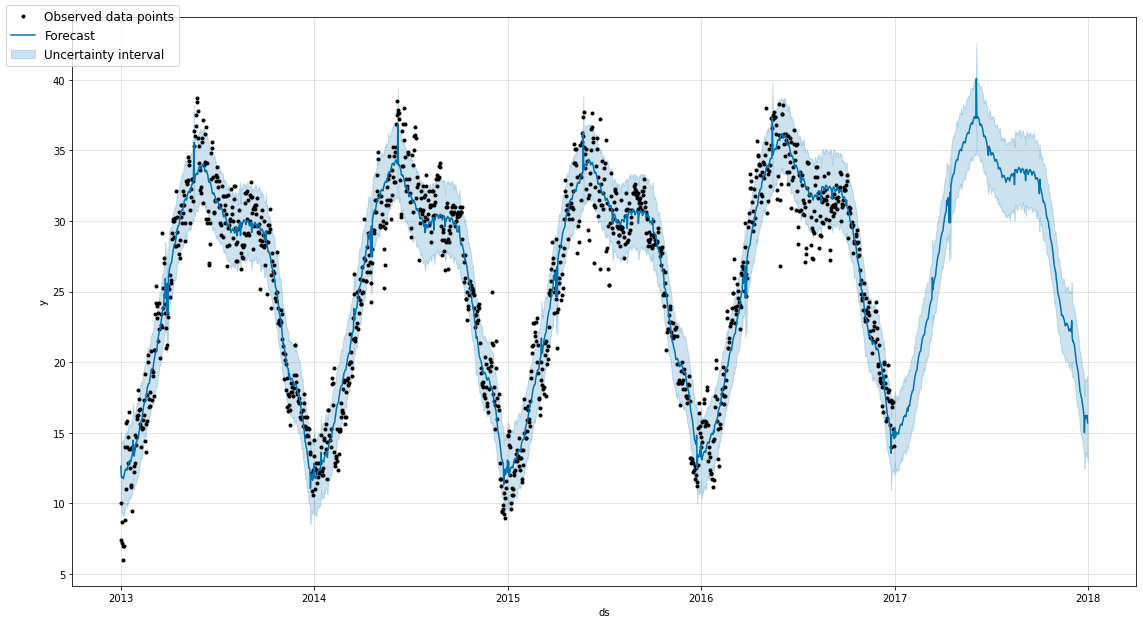

In [103]:
%matplotlib inline

fig = model.plot(forecast)
fig.set_size_inches(16,9)
fig.legend(loc='upper left', fontsize='large')
fig.savefig('../Images/prophet_forecast.png')
plt.show()

c:\Users\ramaz\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
c:\Users\ramaz\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


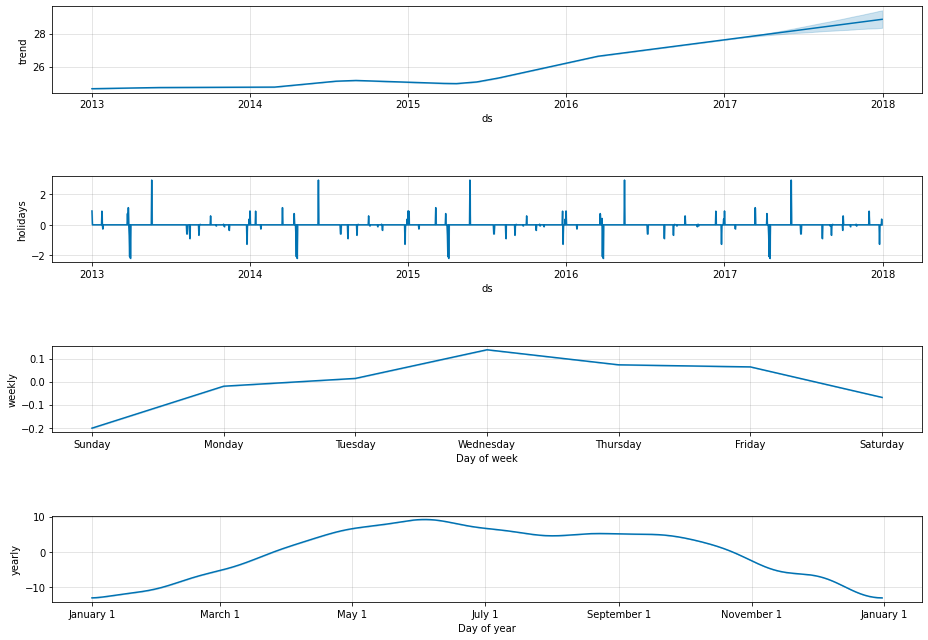

In [104]:
%matplotlib inline

fig = model.plot_components(forecast)
fig.set_size_inches((13,9))
fig.savefig('../Images/prophet_model_components.png')
fig.tight_layout(h_pad=5)
plt.show()

In [118]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast[forecast['ds'] > test.ds.min()].head()

,ds,yhat,yhat_lower,yhat_upper
1463,2017-01-03,14.755816,12.223005,17.266167
1464,2017-01-04,14.934605,12.449101,17.656023
1465,2017-01-05,14.934666,12.307541,17.348205
1466,2017-01-06,15.000082,12.374994,17.659747
1467,2017-01-07,14.949199,12.414332,17.480985


In [119]:
test.head()

,ds,y
1463,2017-01-02,18.500000
1464,2017-01-03,17.111111
1465,2017-01-04,18.700000
1466,2017-01-05,18.388889
1467,2017-01-06,19.318182


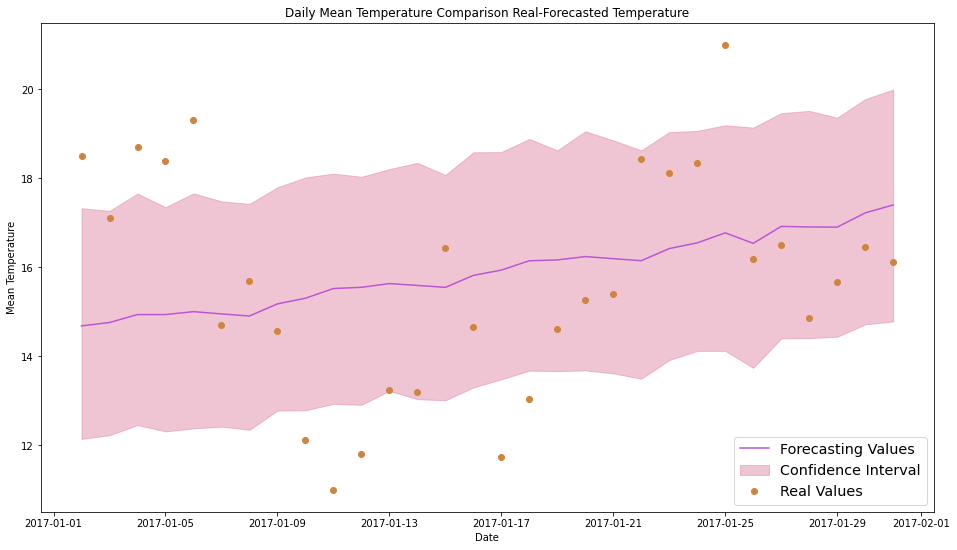

In [125]:
%matplotlib inline 

forecast_sample = pd.DataFrame(forecast[(forecast['ds'] > '2017-01-01') & (forecast['ds'] < '2017-02-01')])
test_sample = pd.DataFrame(test[(test['ds'] > '2017-01-01') & (test['ds'] < '2017-02-01')])

forecast_sample['ds'] = pd.to_datetime(forecast_sample['ds'])
test_sample['ds'] = pd.to_datetime(test_sample['ds'])

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(forecast_sample['ds'], forecast_sample['yhat'],
         color='mediumorchid', label='Forecasting Values')
ax.fill_between(forecast_sample['ds'], forecast_sample['yhat_lower'], forecast_sample['yhat_upper'],
                 color='palevioletred', alpha=.4, label='Confidence Interval')
ax.plot(test_sample['ds'], test_sample['y'],
         linestyle='None', marker='o', label='Real Values', color='peru')

ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature')
ax.set_title('Daily Mean Temperature Comparison Real-Forecasted Temperature')
ax.legend(loc='lower right', fontsize='x-large')

fig.savefig('../Images/prophet_results.png')
plt.show()

In [133]:
forecast[(forecast['ds'] >= test.ds.min()) & (forecast['ds'] <= test.ds.max())].shape

(113, 4)

In [131]:
test.shape

(113, 2)

In [141]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(test['y'], forecast[(forecast['ds'] >= test.ds.min()) & (forecast['ds'] <= test.ds.max())]['yhat'])

f'MAPE: {np.round(MAPE, 4)*100}%'

'MAPE: 11.93%'